In [9]:
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Replace 'Your Folder Path' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/Dataset/cnn-sentiment-twitter-cleaned-trimmed.csv'

df = pd.read_csv(file_path, sep=',', on_bad_lines='skip', encoding='latin-1')

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Tweet,sentiment
0,tahu informasi wilayah jabar dasar level 3 2 1 di,1
1,tempat ibadah wilayah ppkm level 1 kapasitas 1...,1
2,juru bicara satgas covid19 wiku adisasmito jel...,1
3,tahu informasi wilayah jabar dasar level 4 3 2 di,1
4,menteri agama terbit surat edar nomor 062022 l...,1


In [12]:
# prompt: hitung berapa jumlah nilai sentiment 1, 2, dan 0

import pandas as pd
from google.colab import drive



# Count the occurrences of each sentiment value
sentiment_counts = df['sentiment'].value_counts()

# Print the counts
sentiment_counts

,count
sentiment,
1,14349
2,3796
0,1841


In [13]:
# prompt: dataset tersebut sangat tidak seimbang, pangkas beberapa data yang memiliki nilai sentiment "1" menjadi sebanyak 5000 data, lalu gabungkan dengan data asli pada sentiment "2, dan 0"

# Separate dataframes based on sentiment
df_sentiment_1 = df[df['sentiment'] == 1]
df_sentiment_others = df[df['sentiment'] != 1]

# Randomly sample 5000 rows from sentiment 1
df_sentiment_1_sampled = df_sentiment_1.sample(n=5000, random_state=42) # random_state for reproducibility

# Concatenate the sampled sentiment 1 data with other sentiments
df_balanced = pd.concat([df_sentiment_1_sampled, df_sentiment_others], ignore_index=True)

# Verify the new sentiment counts
sentiment_counts_balanced = df_balanced['sentiment'].value_counts()
sentiment_counts_balanced

# Now df_balanced contains the balanced dataset

,count
sentiment,
1,5000
2,3796
0,1841


In [14]:
# prompt: simpan dataset yang sudah di pangkas menjadi dataset baru dalam path ini (My Drive/Dataset/cnn-sentiment-twitter-cleaned-trimmed.csv) gunakan nama "cnn-sentiment-twitter-cleaned-trimmed.csv" pada dataset baru

# Save the balanced dataset to a new CSV file in Google Drive
balanced_file_path = '/content/drive/My Drive/Dataset/cnn-sentiment-twitter-cleaned-trimmed.csv'
df_balanced.to_csv(balanced_file_path, index=False)

In [15]:
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Replace 'Your Folder Path' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/Dataset/cnn-sentiment-twitter-cleaned-trimmed.csv'

df = pd.read_csv(file_path, sep=',', on_bad_lines='skip', encoding='latin-1')

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Tweet,sentiment
0,timbang masalah terap disiplin protokol sehat ...,1
1,gera masyarakat pulau jawa bal alami turun sig...,1
2,kowe butuh leren kowe butuh neng,1
3,borneo fc bantu umkm geliat masa ppkm,1
4,1 komentar ppkm pak presiden kapan mundur sege...,1


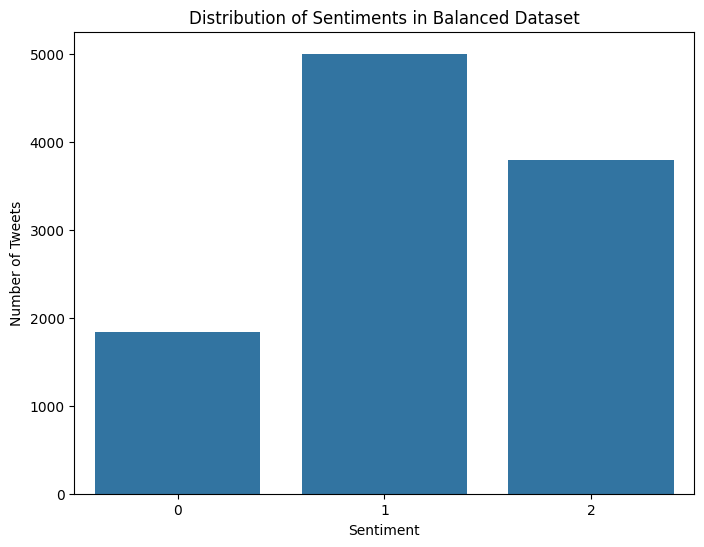

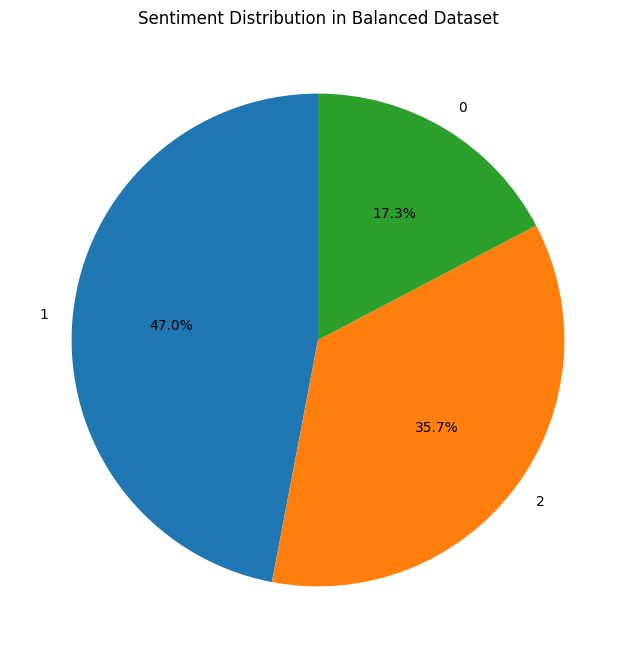

In [16]:
# prompt: visualisasikan menggunakan graph atau chart perbandingan sentiment yang sekarang

import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment value in the balanced dataset
sentiment_counts_balanced = df['sentiment'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts_balanced.index, y=sentiment_counts_balanced.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiments in Balanced Dataset')
plt.show()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts_balanced, labels=sentiment_counts_balanced.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution in Balanced Dataset')
plt.show()

In [17]:
# prompt: saya ingin melakukan teknik oversampling pada kelas minoritas

from imblearn.over_sampling import RandomOverSampler, SMOTE

# Separate features (X) and target variable (y)
X = df.drop('sentiment', axis=1)  # Assuming 'sentiment' is your target column
y = df['sentiment']

# Choose an oversampling technique (RandomOverSampler or SMOTE)
# RandomOverSampler: Duplicates existing samples in the minority class
# SMOTE: Creates synthetic samples by interpolating between existing minority class samples

oversampler = RandomOverSampler(random_state=42)  # You can change the random_state
# oversampler = SMOTE(random_state=42, k_neighbors=5) # Example using SMOTE, adjust k_neighbors if needed

X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new balanced DataFrame
df_oversampled = pd.DataFrame(X_resampled, columns=X.columns)
df_oversampled['sentiment'] = y_resampled

# Check the class distribution after oversampling
print(df_oversampled['sentiment'].value_counts())

# Now you have df_oversampled which contains the oversampled data
# You can proceed with your model training using this balanced dataset



sentiment
1    5000
2    5000
0    5000
Name: count, dtype: int64


In [18]:
#Example saving the file
balanced_file_path = '/content/drive/My Drive/Dataset/cnn-sentiment-twitter-oversampled.csv'
df_oversampled.to_csv(balanced_file_path, index=False)

Modeling Phase

In [23]:
!pip install keras

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import re


In [25]:
# Path dataset
data_path = '/content/drive/My Drive/Dataset/cnn-sentiment-twitter-oversampled.csv'

# Memuat dataset
dataset = pd.read_csv(data_path)

# Menampilkan beberapa baris untuk memastikan data terstruktur dengan benar
print(dataset.head())


                                               Tweet  sentiment
0  timbang masalah terap disiplin protokol sehat ...          1
1  gera masyarakat pulau jawa bal alami turun sig...          1
2                   kowe butuh leren kowe butuh neng          1
3              borneo fc bantu umkm geliat masa ppkm          1
4  1 komentar ppkm pak presiden kapan mundur sege...          1


In [28]:
def clean_text(text):
    # Check if text is a string before applying string methods
    if isinstance(text, str):
        text = text.lower()  # Mengubah ke huruf kecil
        text = re.sub(r"http\S+|www\S+", "", text)  # Menghapus URL
        text = re.sub(r"[^\w\s]", "", text)  # Menghapus tanda baca
        text = re.sub(r"\d+", "", text)  # Menghapus angka
        text = text.strip()  # Menghapus spasi berlebih
        return text
    else:
        # Handle non-string values (e.g., floats, NaNs)
        # You can choose to:
        # 1. Return an empty string: return ''
        # 2. Return the original value as a string: return str(text)
        # 3. Replace with a placeholder: return 'NaN_placeholder'
        # Choose the approach that best suits your data and analysis.
        return ''  # Returning an empty string for now

# Assuming the column with text data is named 'Tweet', you need to change 'text' to 'Tweet'
dataset['clean_text'] = dataset['Tweet'].apply(clean_text)

# Menampilkan teks yang telah dibersihkan
print(dataset['clean_text'].head())

0    timbang masalah terap disiplin protokol sehat ...
1    gera masyarakat pulau jawa bal alami turun sig...
2                     kowe butuh leren kowe butuh neng
3                borneo fc bantu umkm geliat masa ppkm
4    komentar ppkm pak presiden kapan mundur segera...
Name: clean_text, dtype: object


In [29]:
print(dataset.head())

                                               Tweet  sentiment  \
0  timbang masalah terap disiplin protokol sehat ...          1   
1  gera masyarakat pulau jawa bal alami turun sig...          1   
2                   kowe butuh leren kowe butuh neng          1   
3              borneo fc bantu umkm geliat masa ppkm          1   
4  1 komentar ppkm pak presiden kapan mundur sege...          1   

                                          clean_text  
0  timbang masalah terap disiplin protokol sehat ...  
1  gera masyarakat pulau jawa bal alami turun sig...  
2                   kowe butuh leren kowe butuh neng  
3              borneo fc bantu umkm geliat masa ppkm  
4  komentar ppkm pak presiden kapan mundur segera...  


In [30]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet       14999 non-null  object
 1   sentiment   15000 non-null  int64 
 2   clean_text  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [31]:
# Tokenisasi teks menjadi daftar kata
tokenized_texts = [text.split() for text in dataset['clean_text']]

# Membuat Word2Vec model dengan CBOW
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, sg=0)  # sg=0 untuk CBOW

# Melihat jumlah kata dalam vocab
print(f"Jumlah kata dalam vocab: {len(word2vec_model.wv.index_to_key)}")


Jumlah kata dalam vocab: 8826


In [33]:
# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['clean_text'])
word_index = tokenizer.word_index

# Mengonversi teks ke urutan token
sequences = tokenizer.texts_to_sequences(dataset['clean_text'])

# Padding sequences agar memiliki panjang yang sama
max_len = 100  # Panjang maksimum sequence
X = pad_sequences(sequences, maxlen=max_len)

# Konversi label ke one-hot encoding
y = tf.keras.utils.to_categorical(dataset['sentiment'])


In [34]:
embedding_dim = 100  # Dimensi Word2Vec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Membuat model CNN
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))

# Convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flattening
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,460,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,000 (5.57 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,460,000 (5.57 MB)

None


In [36]:
# Melatih model
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5555 - loss: 0.9171 - val_accuracy: 0.4587 - val_loss: 1.0995
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6635 - loss: 0.7807 - val_accuracy: 0.6607 - val_loss: 0.7589
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6644 - loss: 0.7642 - val_accuracy: 0.6270 - val_loss: 0.8073
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6862 - loss: 0.7165 - val_accuracy: 0.6443 - val_loss: 0.7970
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7099 - loss: 0.6846 - val_accuracy: 0.6027 - val_loss: 0.8895
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7305 - loss: 0.6445 - val_accuracy: 0.7147 - val_loss: 0.6891
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7438 - loss: 0.6214 - val_accuracy: 0.7543 - val_loss: 0.6051
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7473 - loss: 0.5816 - val_accuracy: 0.

In [37]:
# Evaluasi model
loss, accuracy = model.evaluate(X, y)
print(f"Akurasi model: {accuracy * 100:.2f}%")


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8172 - loss: 0.4302
Akurasi model: 82.36%


In [38]:
# Contoh prediksi
sample_text = ["Layanan ini sangat buruk!"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
prediction = model.predict(sample_pad)

print("Prediksi:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Prediksi: [[0.36352062 0.2866964  0.349783  ]]


In [44]:
# prompt: pada prediksi gunakan format persen, dan beri nama mana sentiment 1, 2, dan 0

# ... (your existing code)

# Contoh prediksi
sample_text = ["pena knp padam apa ikut jg th tlg chek donk"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
prediction = model.predict(sample_pad)

# Convert prediction probabilities to percentages
prediction_percentages = prediction * 100

# Find the sentiment with the highest probability
predicted_sentiment_index = np.argmax(prediction)

# Define sentiment labels
sentiment_labels = {
    0: "positif",
    1: "netral",
    2: "negatif"
}


print("Prediksi:")
for i, percentage in enumerate(prediction_percentages[0]):
    print(f"{sentiment_labels[i]}: {percentage:.2f}%")

print(f"Sentiment dengan probabilitas tertinggi: {sentiment_labels[predicted_sentiment_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediksi:
positif: 17.13%
netral: 54.97%
negatif: 27.90%
Sentiment dengan probabilitas tertinggi: netral


In [46]:
# prompt: buatlah skema user akan menginputkan lalu mesin akan memprediksi sentimen

# ... (your existing code)

# Function to predict sentiment
def predict_sentiment(text):
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_pad = pad_sequences(sample_seq, maxlen=max_len)
    prediction = model.predict(sample_pad)
    prediction_percentages = prediction * 100
    predicted_sentiment_index = np.argmax(prediction)

    sentiment_labels = {
        0: "positif",
        1: "netral",
        2: "negatif"
    }

    results = {}
    for i, percentage in enumerate(prediction_percentages[0]):
        results[sentiment_labels[i]] = f"{percentage:.2f}%"

    return results, sentiment_labels[predicted_sentiment_index]


# Get user input
user_input = input("Masukkan teks: ")

# Predict sentiment
predictions, predicted_label = predict_sentiment(user_input)

# Print the results
print("Prediksi:")
for sentiment, percentage in predictions.items():
    print(f"{sentiment}: {percentage}")

print(f"Sentiment dengan probabilitas tertinggi: {predicted_label}")

Masukkan teks: ppkm membuat saya stress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediksi:
positif: 3.22%
netral: 32.04%
negatif: 64.74%
Sentiment dengan probabilitas tertinggi: negatif
